In [2]:
# Basic data manipulations
import pandas as pd
import numpy as np


# Handling images
from PIL import Image
import matplotlib.pyplot as plt

# Handling paths

import time

# Pytorch essentials
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import models
from torchvision.datasets import ImageFolder
! pip install torchsummary
import torchsummary



# Pytorch essentials for datasets.
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# Pytorch way of data augmentation.
import torchvision
from torchvision import datasets, models, transforms, utils
from torchvision.transforms import v2

import cv2
import os
from glob import glob
from tqdm import tqdm
import shutil
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

In [3]:
root_path = '/drive/input/defungi'
df = pd.DataFrame({"path":[],"label":[], "class_id":[]})
label_dict = {
    "H1":0,
    "H2":1,
    "H3":2,
    "H5":3,
    "H6":4,
}
for key in label_dict:
    img_path = os.path.join(root_path, key)
    jpg_list = glob(img_path+'/*.jpg')
    for jpg in jpg_list:
        new_data =pd.DataFrame({"path":jpg,"label":key, "class_id":label_dict[key]}, index=[1])
        df = pd.concat([df, new_data], ignore_index=True)

df[["path"]] = df[["path"]].astype(str)
df[["label"]] = df[["label"]].astype(str)
df[["class_id"]] = df[["class_id"]].astype(int)

(array([4404.,    0., 2334.,    0.,    0.,  819.,    0.,  818.,    0.,
         739.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

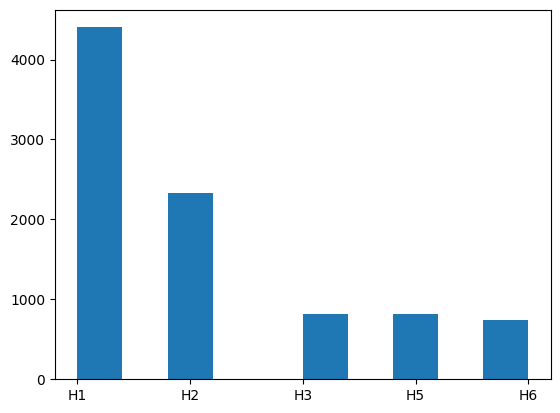

In [4]:
plt.hist(df['label'])

In [5]:
train_transforms = v2.Compose([
    v2.Resize(256),
    v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
   
    v2.RandomAffine(degrees=(-10, 10), translate=(0.1, 0.1), scale=(0.9, 1.1)),
    v2.RandomErasing(p=0.5, scale=(0.1,0.15)),
    v2.PILToTensor(),
    v2.ToDtype(torch.float32),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

])

test_transforms = v2.Compose([
    v2.Resize((224,224)),
    v2.PILToTensor(),
    v2.ToDtype(torch.float32),
    v2.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

In [6]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transforms_):
        self.df = dataframe
        self.transforms_ = transforms_
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        image_path = self.df.iloc[index]['path']
       
        img = Image.open(image_path).convert("RGB")
     
        transformed_img = self.transforms_(img)
        class_id = self.df.iloc[index]['class_id']
        return transformed_img, class_id

In [7]:
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
num_workers = 2 if device=='cuda' else 4 

train_df, val_df = train_test_split(df,test_size=0.2)
train_dataset = MyDataset(train_df, train_transforms)
val_dataset = MyDataset(val_df, test_transforms)

BATCH_SIZE = 8
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

In [8]:
dataiter = iter(train_loader)

images,labels = next(dataiter)

print(type(images))

print(images.shape)

<class 'torch.Tensor'>
torch.Size([8, 3, 224, 224])


In [18]:
class SimpleDNN(nn.Module):
    def __init__(self):
        super(SimpleDNN, self).__init__()
        self.fc1 = nn.Linear(3*224*224, 1020)  
        self.fc2 = nn.Linear(1020, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 64)
        self.fc6 = nn.Linear(64, 32)
        self.fc7 = nn.Linear(32, 16)
        self.fc8 = nn.Linear(16, 5)

    def forward(self, x):
        x = x.view(-1, 3*224*224) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = F.relu(self.fc7(x))
        x = self.fc8(x)
        return x

In [19]:

model = SimpleDNN()

print(model)


SimpleDNN(
  (fc1): Linear(in_features=150528, out_features=1020, bias=True)
  (fc2): Linear(in_features=1020, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=128, bias=True)
  (fc5): Linear(in_features=128, out_features=64, bias=True)
  (fc6): Linear(in_features=64, out_features=32, bias=True)
  (fc7): Linear(in_features=32, out_features=16, bias=True)
  (fc8): Linear(in_features=16, out_features=5, bias=True)
)


In [21]:
from torchsummary import summary

In [22]:
#model.summary()

In [23]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset) 
    num_batches = len(dataloader) 
    model.train()
    epoch_loss = 0.0
    epoch_correct = 0 
    for (data_,target_) in dataloader:
        target_ = target_.type(torch.LongTensor)
        data_, target_ = data_.to(device), target_.to(device)
        
        
        optimizer.zero_grad()
        
     
        outputs = model(data_)
        
     
        loss = criterion(outputs,target_)
        
    
        loss.backward()
        
     
        optimizer.step()
        
       
        epoch_loss = epoch_loss + loss.item()
        _,pred = torch.max(outputs,dim=1)
        epoch_correct = epoch_correct + torch.sum(pred == target_).item()
    return epoch_correct/size, epoch_loss/num_batches

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset) 
    num_batches = len(dataloader) 
    epoch_loss = 0.0
    epoch_correct = 0 
    with torch.no_grad():
       
        model.eval()
        for (data_,target_) in dataloader:
            target_ = target_.type(torch.LongTensor)
            data_, target_ = data_.to(device), target_.to(device)

        
            outputs = model(data_)
            
        
            loss = criterion(outputs,target_)
        
            epoch_loss = epoch_loss + loss.item()
            _,pred = torch.max(outputs,dim=1)
            epoch_correct = epoch_correct + torch.sum(pred == target_).item()
    return  epoch_correct/size, epoch_loss/num_batches

In [24]:
model.to(device)
EPOCHS = 50

logs = {
    'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []
}

criterion  = nn.CrossEntropyLoss()
learning_rate = 0.0001
momentum = 0.9
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)



patience = 5
counter = 0
best_loss = np.inf

for epoch in tqdm(range(EPOCHS)):
    train_acc, train_loss,  = train(train_loader, model, criterion, optimizer)
    val_acc, val_loss = test(val_loader, model, criterion)
    print(f'EPOCH: {epoch} \
    train_loss: {train_loss:.4f}, train_acc: {train_acc:.3f} \
    val_loss: {val_loss:.4f}, val_acc: {val_acc:.3f}')
    
    logs['train_loss'].append(train_loss)
    logs['train_acc'].append(train_acc)
    logs['val_loss'].append(val_loss)
    logs['val_acc'].append(val_acc)
    torch.save(model.state_dict(), "last.pth")
    
    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        torch.save(model.state_dict(), "best.pth")
    else:
        counter += 1
    if counter >= patience:
        print("Earlystop!")
        break

  0%|          | 0/50 [00:00<?, ?it/s]

EPOCH: 0     train_loss: 2.1999, train_acc: 0.391     val_loss: 1.4115, val_acc: 0.491


  2%|▏         | 1/50 [03:12<2:36:59, 192.24s/it]

EPOCH: 1     train_loss: 1.3989, train_acc: 0.452     val_loss: 1.3053, val_acc: 0.492


  4%|▍         | 2/50 [05:26<2:06:17, 157.86s/it]

EPOCH: 2     train_loss: 1.3181, train_acc: 0.487     val_loss: 1.1927, val_acc: 0.551


  6%|▌         | 3/50 [07:39<1:54:53, 146.67s/it]

EPOCH: 3     train_loss: 1.2433, train_acc: 0.515     val_loss: 1.1104, val_acc: 0.559


  8%|▊         | 4/50 [09:53<1:48:46, 141.88s/it]

EPOCH: 4     train_loss: 1.1599, train_acc: 0.548     val_loss: 1.0698, val_acc: 0.583


 10%|█         | 5/50 [12:06<1:43:52, 138.50s/it]

EPOCH: 5     train_loss: 1.1308, train_acc: 0.558     val_loss: 1.0531, val_acc: 0.583


 12%|█▏        | 6/50 [14:19<1:40:18, 136.79s/it]

EPOCH: 6     train_loss: 1.1303, train_acc: 0.554     val_loss: 1.0424, val_acc: 0.589


 14%|█▍        | 7/50 [16:32<1:37:03, 135.44s/it]

EPOCH: 7     train_loss: 1.1180, train_acc: 0.561     val_loss: 1.0432, val_acc: 0.583


 16%|█▌        | 8/50 [18:44<1:33:55, 134.17s/it]

EPOCH: 8     train_loss: 1.1061, train_acc: 0.563     val_loss: 1.1003, val_acc: 0.555


 18%|█▊        | 9/50 [20:55<1:31:02, 133.24s/it]

EPOCH: 9     train_loss: 1.1113, train_acc: 0.559     val_loss: 1.0347, val_acc: 0.597


 20%|██        | 10/50 [23:07<1:28:42, 133.07s/it]

EPOCH: 10     train_loss: 1.1033, train_acc: 0.564     val_loss: 1.1266, val_acc: 0.569


 22%|██▏       | 11/50 [25:19<1:26:18, 132.77s/it]

EPOCH: 11     train_loss: 1.0929, train_acc: 0.567     val_loss: 1.0441, val_acc: 0.593


 24%|██▍       | 12/50 [27:32<1:23:59, 132.61s/it]

EPOCH: 12     train_loss: 1.0882, train_acc: 0.569     val_loss: 1.1955, val_acc: 0.547


 26%|██▌       | 13/50 [29:43<1:21:33, 132.26s/it]

EPOCH: 13     train_loss: 1.1040, train_acc: 0.565     val_loss: 1.0542, val_acc: 0.586


 28%|██▊       | 14/50 [31:56<1:19:26, 132.41s/it]

EPOCH: 14     train_loss: 1.0984, train_acc: 0.564     val_loss: 1.3836, val_acc: 0.311


 28%|██▊       | 14/50 [34:07<1:27:45, 146.26s/it]

Earlystop!


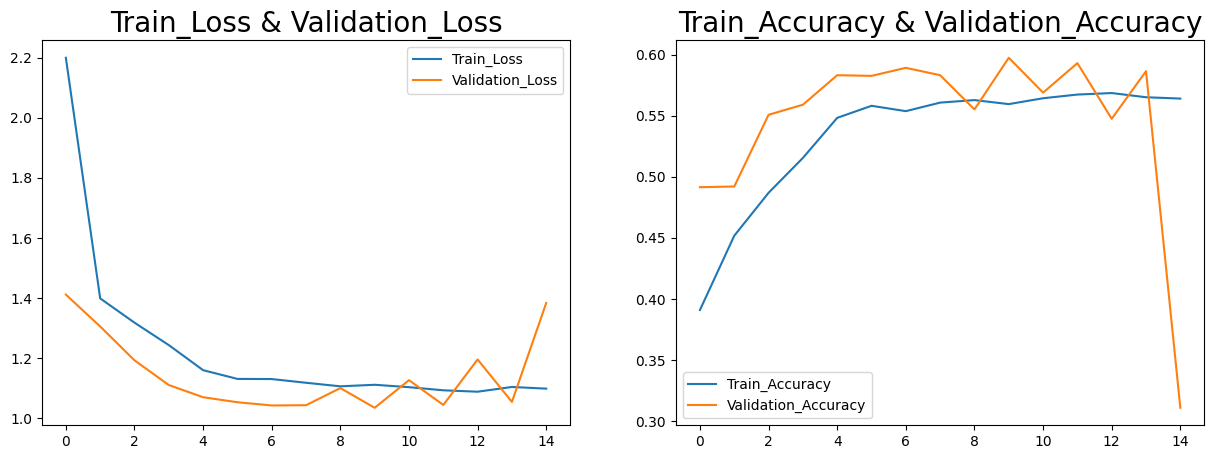

In [25]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(logs['train_loss'],label='Train_Loss')
plt.plot(logs['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(logs['train_acc'],label='Train_Accuracy')
plt.plot(logs['val_acc'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()